In [573]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt

%matplotlib notebook

Загрузим и проанализируем данные

In [574]:
data = pd.read_csv('RDC_samples/train.csv')

In [575]:
data.head()

,No.,Time,Source,Destination,Protocol,Length,Info
0,1,0.000000,10.0.151.43,10.0.16.14,TCP,1026,"8000 > 63774 [PSH, ACK] Seq=1 Ack=1 Win=229 ..."
1,2,0.000004,10.0.151.43,10.0.16.14,TCP,1026,"[TCP Retransmission] 8000 > 63774 [PSH, ACK]..."
2,3,0.000019,10.0.4.66,10.0.17.129,TCP,70,445 > 36384 [ACK] Seq=1 Ack=1 Win=2573 Len=0...
3,4,0.000021,10.0.4.66,10.0.17.129,TCP,70,[TCP Dup ACK 3#1] 445 > 36384 [ACK] Seq=1 Ac...
4,5,0.000055,10.0.16.14,10.0.151.43,TCP,64,63774 > 8000 [ACK] Seq=1 Ack=1 Win=4096 Len=0


In [576]:
data.Protocol.count()

269306

In [577]:
data.Protocol.loc[data.Protocol == 'TCP'].count()

269306

In [578]:
data.Info.apply(lambda x: x.find('Win') != -1).count()

269306

Распарсим колонку Info и оцифруем Ip адреса 

In [579]:
def parse_data(par_list):
    par_list = par_list.split()

    if not par_list[0].isdigit():
        counter = 0
        while not par_list[counter].isdigit():
            counter+=1        
        par_list = par_list[counter:]

    source_port = int(par_list[0])
    destination_port = int(par_list[2])
    windows_size_val = 0

    for it in par_list:
        if it.find('Win')!=-1:
            windows_size_val = int(it[4:])
            break
    return [source_port, destination_port, windows_size_val]

In [635]:
def data_init(file_name='train.csv'):
    data = pd.read_csv('RDC_samples/'+file_name)
    data['params'] = data.Info.apply(parse_data)
    data[['source_port', 'destination_port', 'windows_size_val']] = pd.DataFrame(data.params.tolist(), index=data.index)
    data = data.drop(columns=['params', 'Info', 'Protocol', 'Time', 'No.'])
    data.Source = data.Source.apply(lambda x: int(x.replace('.', '')) if x.replace('.', '').isdigit() else None)
    data.Destination = data.Destination.apply(lambda x: int(x.replace('.', '')) if x.replace('.', '').isdigit() else None)
    return data

In [581]:
data = data_init('train.csv')

In [582]:
data.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
0,10015143,1001614,1026,8000,63774,229
1,10015143,1001614,1026,8000,63774,229
2,100466,10017129,70,445,36384,2573
3,100466,10017129,70,445,36384,2573
4,1001614,10015143,64,63774,8000,4096


Посмотрим сколько уникальных элементов и построим гистограммы, чтобы понять, какие элементы считать аномалиями

In [583]:
data.nunique()

Source               31
Destination          40
Length              497
source_port         162
destination_port     90
windows_size_val    607
dtype: int64

<IPython.core.display.Javascript object>


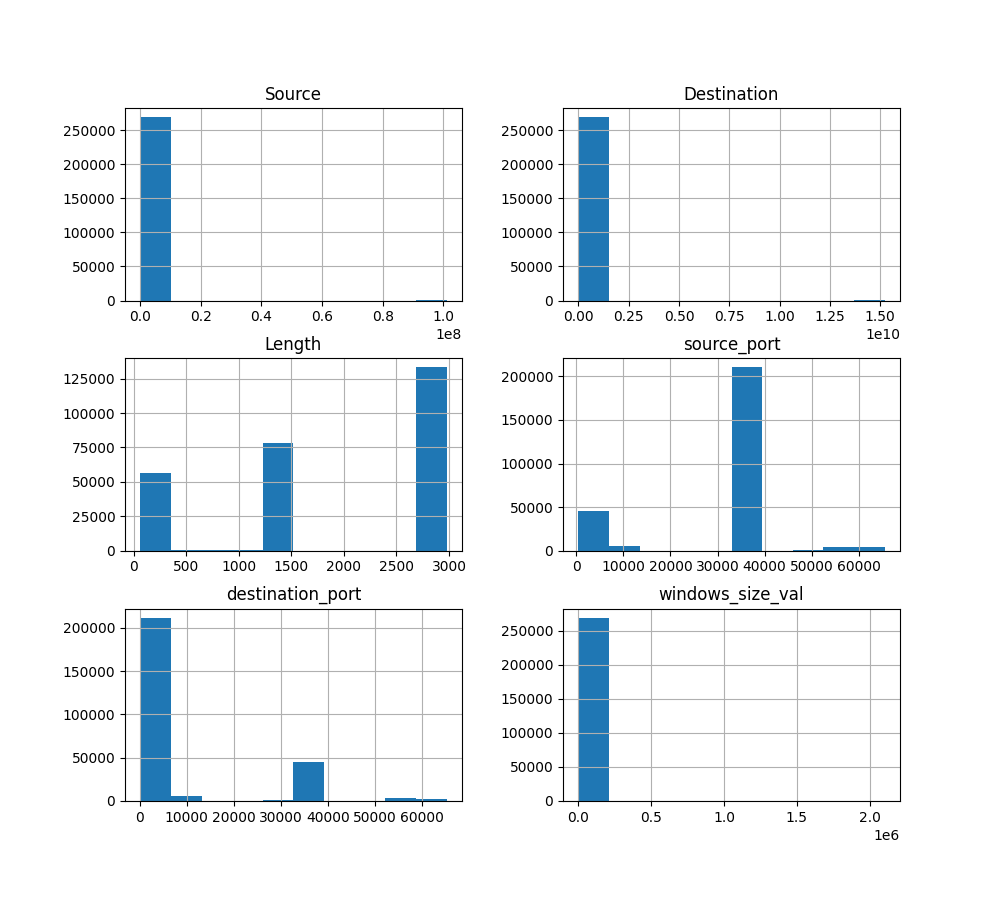

array([[<AxesSubplot:title={'center':'Source'}>,
        <AxesSubplot:title={'center':'Destination'}>],
       [<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'source_port'}>],
       [<AxesSubplot:title={'center':'destination_port'}>,
        <AxesSubplot:title={'center':'windows_size_val'}>]], dtype=object)

In [584]:
data.hist(figsize=(10, 9))

<IPython.core.display.Javascript object>


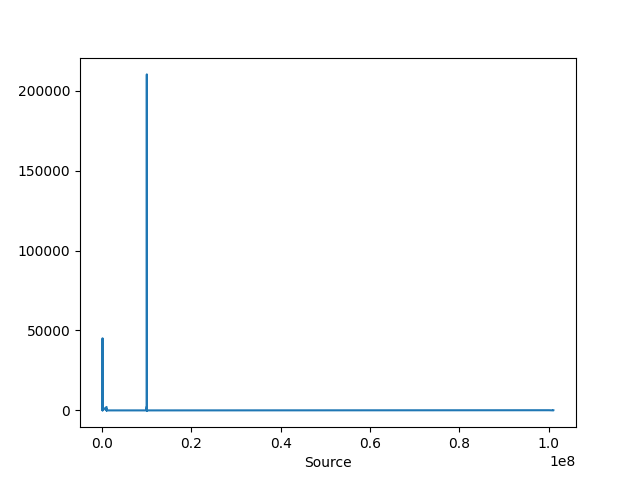

<AxesSubplot:xlabel='Source'>

In [585]:
plt.figure()
data.groupby('Source').Destination.count().rename({'Destination':'count'}).plot()

Заметим, что практически все запросы приходили с 2-ух ресурсов, поэтому избавимся от всех остальных элеметов, чтобы не переобучить модель на выбросах 

In [586]:
fil_sources = data.groupby('Source').Destination.count().sort_values(ascending=False)[:2].index

In [587]:
fil_sources

Int64Index([10017129, 100466], dtype='int64', name='Source')

In [588]:
data = data.loc[(data.Source == fil_sources[0]) | (data.Source == fil_sources[1])] 

In [589]:
data.groupby('Source').Destination.count().sort_values(ascending=False)

Source
10017129    210250
100466       45116
Name: Destination, dtype: int64

<IPython.core.display.Javascript object>


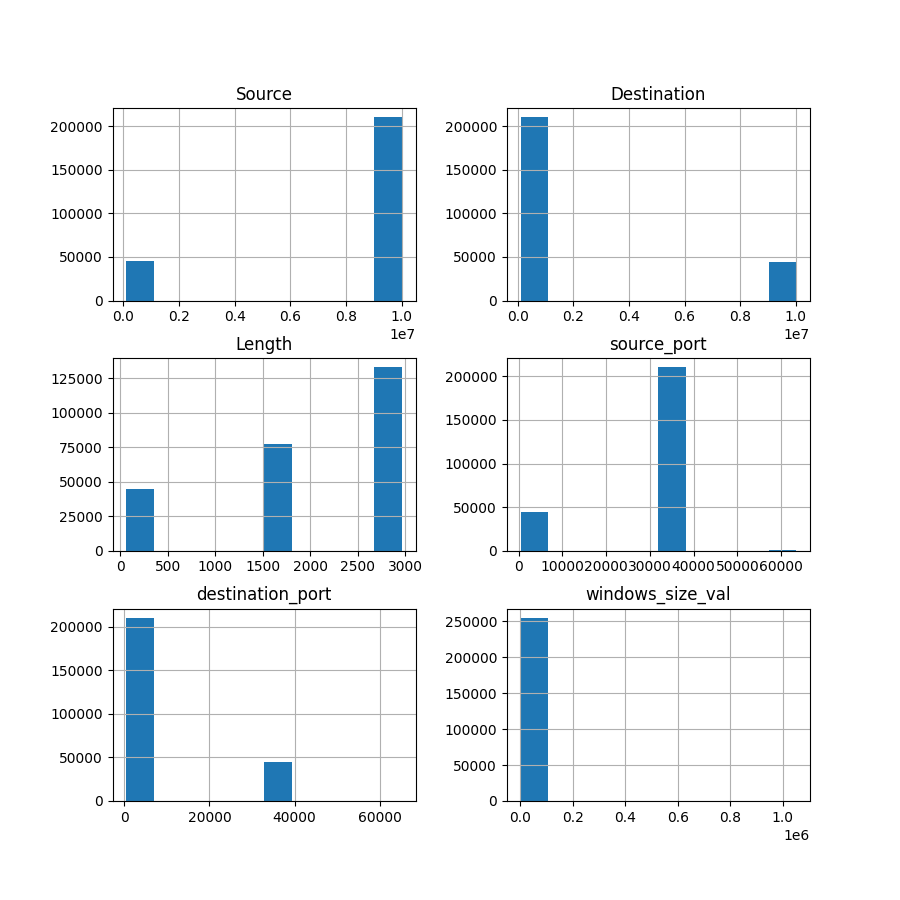

array([[<AxesSubplot:title={'center':'Source'}>,
        <AxesSubplot:title={'center':'Destination'}>],
       [<AxesSubplot:title={'center':'Length'}>,
        <AxesSubplot:title={'center':'source_port'}>],
       [<AxesSubplot:title={'center':'destination_port'}>,
        <AxesSubplot:title={'center':'windows_size_val'}>]], dtype=object)

In [590]:
data.hist(figsize=(9,9))

Заметим, что убрав необычные источники данных, на остальных графиках также практически изчезли аномалии

Создадим полносвязную нейронную сеть, задачей которой будет на выходе давать результат схожий с тем, что был на входе, тогда при наличии аномалий, нейронная сеть будет давать большую ошибку, что можно будет отследить

In [591]:
import torch
from torch import nn

In [592]:
X = torch.FloatTensor(np.asarray(data))

In [593]:
train_data_size = int(0.8*X.shape[0])
X_train, X_val = X[:train_data_size], X[train_data_size:]

In [594]:
X_train.shape

torch.Size([204292, 6])

In [595]:
X_val.shape

torch.Size([51074, 6])

In [596]:
features_count = X_train.shape[1]
rows = X_train.shape[0]
learning_rate = 1e-3
batch_size = 700
epochs = 5

In [597]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [598]:
model = nn.Sequential(
    nn.Linear(features_count, 32),
    nn.ReLU(),
    nn.Linear(32,48),
    nn.ReLU(),
    nn.Linear(48,64),
    nn.ReLU(),
    nn.Linear(64,32),
    nn.ReLU(),
    nn.Linear(32,features_count)
)
model.to(device)

Sequential(
  (0): Linear(in_features=6, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=48, bias=True)
  (3): ReLU()
  (4): Linear(in_features=48, out_features=64, bias=True)
  (5): ReLU()
  (6): Linear(in_features=64, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=6, bias=True)
)

In [599]:
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [600]:
loss_history = []
for epoch in range(epochs):
    for b_num in range(rows//batch_size):
        batch_X = X_train[b_num*batch_size:(b_num+1)*batch_size]
        batch_X = batch_X.to(device)
        pred = model.forward(batch_X)
        loss = criterion(pred, batch_X)
        loss_history.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    print(loss_history[-1])

33165.60546875
13772.0380859375
12795.9677734375
21232.4609375
11020.5830078125


<IPython.core.display.Javascript object>


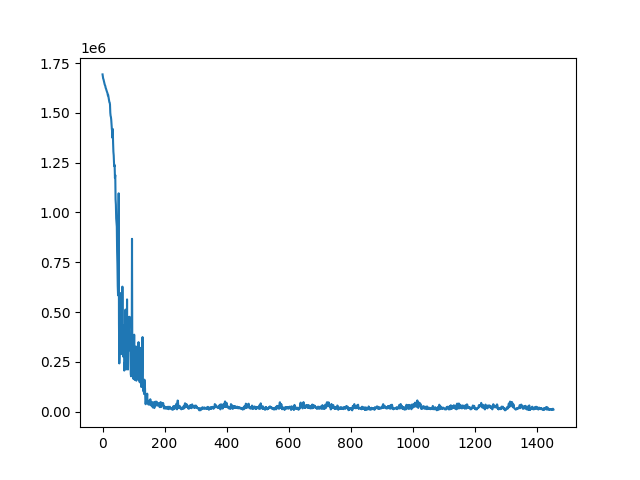

In [601]:
plt.figure()
plt.plot(loss_history)

In [602]:
loss_history[-1]

11020.5830078125

Осталась достаточно большая ошибка, но при этом она стабильная, то есть если в данных будут аномалии, то ошибка, предположительно, будет гораздо больше

Сделаем прямой проход на валидационных данных и найдем l1 метрику для каждого элемента

In [603]:
def predict(X_to_pred):
    with torch.no_grad():
        rows = X_to_pred.shape[0]
        predictions = np.array([[0]*features_count])
        for b_num in range(rows//batch_size):
            batch_X = X_to_pred[b_num*batch_size:(b_num+1)*batch_size]
            pred = np.asarray(model.forward(batch_X))
            predictions = np.vstack((predictions, pred))
        batch_X = X_to_pred[(rows//batch_size)*batch_size:]
        pred = np.asarray(model.forward(batch_X))
        predictions = np.vstack((predictions, pred))
    return predictions[1:]

In [604]:
model.cpu()
preds = predict(X_val)
preds

array([[ 9.97672200e+06,  1.06646609e+05, -1.34886172e+04,
         5.23496250e+04,  8.76808398e+03, -3.69163965e+03],
       [ 9.97672200e+06,  1.06646609e+05, -1.34886172e+04,
         5.23496250e+04,  8.76808398e+03, -3.69163965e+03],
       [ 9.97735800e+06,  1.06593328e+05, -1.35018672e+04,
         5.23475000e+04,  8.77811523e+03, -3.68693652e+03],
       ...,
       [ 9.97735800e+06,  1.06593328e+05, -1.35018672e+04,
         5.23475000e+04,  8.77811523e+03, -3.68693652e+03],
       [ 9.97735800e+06,  1.06593328e+05, -1.35018672e+04,
         5.23475000e+04,  8.77811523e+03, -3.68693652e+03],
       [ 9.97672200e+06,  1.06646609e+05, -1.34886172e+04,
         5.23496250e+04,  8.76808398e+03, -3.69163965e+03]])

In [605]:
preds.shape

(51074, 6)

In [606]:
X_val_tmp = np.asarray(X_val)
losses = np.sum(np.abs(X_val_tmp - preds),axis=1)
print(losses.shape)


(51074,)


<IPython.core.display.Javascript object>


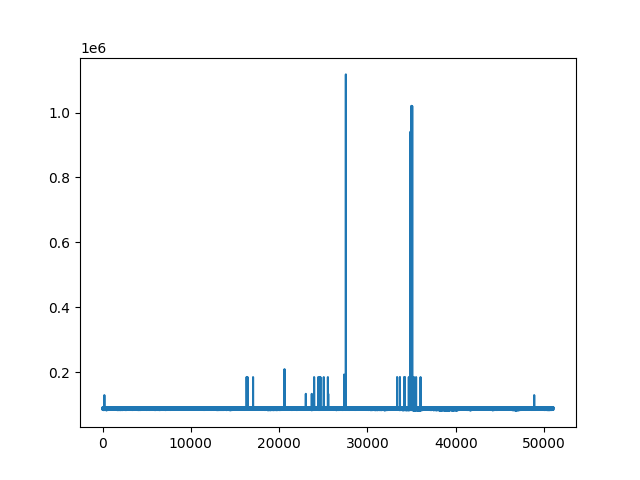

In [607]:
plt.figure()
plt.plot(losses)

In [608]:
losses = pd.Series(losses)
losses.loc[losses > 0.4*1e6]

27558    1.117420e+06
27559    1.117420e+06
34883    9.412068e+05
34884    9.412068e+05
34983    1.020660e+06
34984    1.020660e+06
34985    1.020654e+06
34986    1.020654e+06
35069    1.019891e+06
35070    1.019891e+06
35071    1.019891e+06
35072    1.019891e+06
35075    1.019891e+06
35076    1.019891e+06
dtype: float64

Нашли индексы элементов из первоначального датасета которые модель посчитала аномалиями
Заметим, что на обучающих данных ошибка была не такая стабильная как на валидационных, но при этом и аномалий заметно не было, потому что на тестовых данных считалась средняя ошибка на батче.

Проведем аналогичный анализ на первом тестовом датасете

In [609]:
test_data_1 = data_init('test_1.csv')

In [610]:
test_data_1.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
0,1004245,10016152,1518,3128,62408,513
1,1004245,10016152,2978,3128,62408,513
2,1004245,10016152,2978,3128,62408,513
3,1004245,10016152,2978,3128,62408,513
4,1004245,10016152,2973,3128,62408,513


In [612]:
test_data_1.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

In [613]:
X_test = torch.FloatTensor(np.asarray(test_data_1))
X_test.shape

torch.Size([268378, 6])

In [614]:
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
print(losses.shape)

(268378,)


<IPython.core.display.Javascript object>


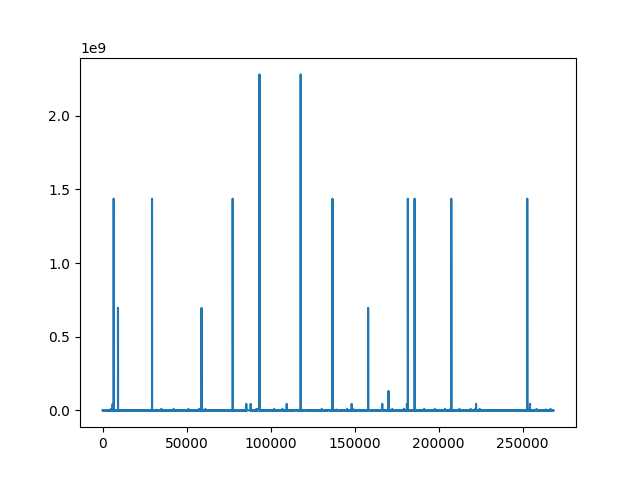

In [615]:
plt.figure()
plt.plot(losses)

In [616]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e9]

In [617]:
losses

6618      1.436555e+09
6619      1.436555e+09
9190      6.958167e+08
9191      6.958167e+08
29443     1.436555e+09
29444     1.436555e+09
58902     6.958167e+08
58903     6.958167e+08
77444     1.436555e+09
77445     1.436555e+09
93418     2.280117e+09
93419     2.280117e+09
117922    2.280117e+09
117923    2.280117e+09
136857    1.436555e+09
136858    1.436555e+09
158076    6.958167e+08
158077    6.958167e+08
181706    1.436555e+09
181707    1.436555e+09
185724    1.436555e+09
185725    1.436555e+09
207565    1.436555e+09
207566    1.436555e+09
252778    1.436555e+09
252779    1.436555e+09
dtype: float64

In [618]:
test_data_1_abnormal = test_data_1.loc[losses.index]

In [619]:
test_data_1_abnormal

,Source,Destination,Length,source_port,destination_port,windows_size_val
6618,10016139,82202185148,70,50624,443,64240
6619,10016139,82202185148,70,50624,443,64240
9190,10016139,40127240158,70,50623,443,64240
9191,10016139,40127240158,70,50623,443,64240
29443,10016139,82202185148,70,50624,443,64240
29444,10016139,82202185148,70,50624,443,64240
58902,10016139,40127240158,70,50623,443,64240
58903,10016139,40127240158,70,50623,443,64240
77444,10016139,82202185148,70,50624,443,64240
77445,10016139,82202185148,70,50624,443,64240


Проанализируем второй тестовый датасет

In [636]:
test_data_2 = data_init('test_2.csv')

In [637]:
test_data_2.isnull().sum()

Source              50
Destination         50
Length               0
source_port          0
destination_port     0
windows_size_val     0
dtype: int64

In [638]:
test_data_2 = test_data_2.dropna()

In [639]:
test_data_2.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

<IPython.core.display.Javascript object>


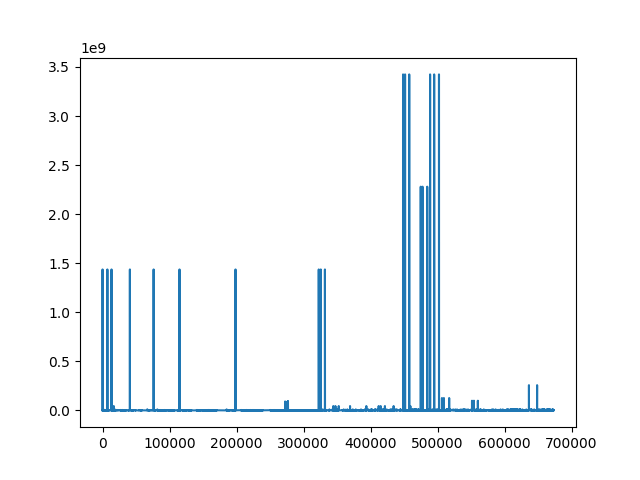

In [640]:
X_test = torch.FloatTensor(np.asarray(test_data_2))
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
plt.figure()
plt.plot(losses)

In [641]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e9]

In [643]:
test_data_2_abnormal = test_data_2.loc[losses.index]
test_data_2_abnormal.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
15,10016140.0,8.220218e+10,70,55002,443,64240
7212,10016140.0,8.220218e+10,70,55003,443,64240
7213,10016140.0,8.220218e+10,70,55003,443,64240
13390,10016140.0,8.220218e+10,70,55003,443,64240
13391,10016140.0,8.220218e+10,70,55003,443,64240


Проанализируем третий тестовый датасет

In [650]:
test_data_3 = data_init('test_3.csv')

In [651]:
test_data_3.isnull().sum()

Source              0
Destination         0
Length              0
source_port         0
destination_port    0
windows_size_val    0
dtype: int64

<IPython.core.display.Javascript object>


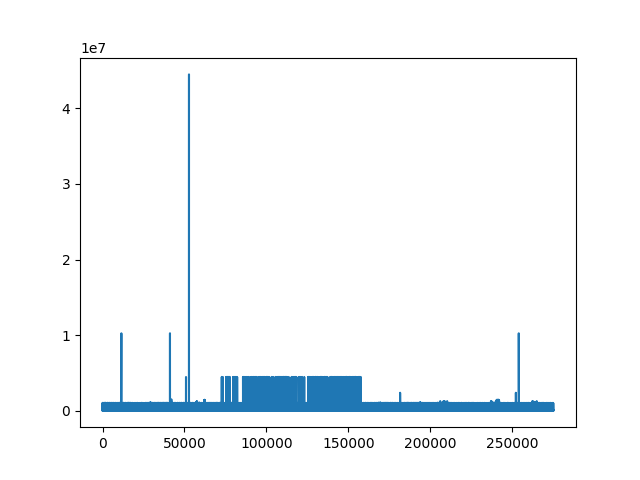

In [694]:
X_test = torch.FloatTensor(np.asarray(test_data_3))
preds = predict(X_test)
X_test_tmp = np.asarray(X_test)
losses = np.sum(np.abs(X_test_tmp - preds),axis=1)
plt.figure()
plt.plot(losses)

In [697]:
losses = pd.Series(losses)
losses = losses.loc[losses > 0.5 * 1e7]
losses.shape

(8,)

In [698]:
test_data_3_abnormal = test_data_3.loc[losses.index]
test_data_3_abnormal.head()

,Source,Destination,Length,source_port,destination_port,windows_size_val
11488,10108115,100109143,70,57986,13000,65535
11489,10108115,100109143,70,57986,13000,65535
41145,10108122,100112228,70,63396,13000,65535
41146,10108122,100112228,70,63396,13000,65535
52750,101081134,100112228,70,58743,13000,65535
